In [150]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
!pip install pmdarima

In [152]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [153]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/content/drive/MyDrive/Intro_DS_2021/Preprocessing Data/SAVA_preprocessed.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [154]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-11-27,135.73,136.50,135.63,135.63,79.04,700
2000-11-28,133.00,135.63,131.25,131.25,76.49,929
2000-11-29,131.25,133.00,112.00,122.94,71.64,3229
2000-11-30,119.00,120.75,107.19,112.00,65.27,2186
2000-12-01,112.00,115.50,110.25,115.50,67.31,6243
...,...,...,...,...,...,...
2021-11-18,48.49,51.42,46.30,48.44,48.44,6761600
2021-11-19,48.94,55.82,48.70,53.19,53.19,6210000
2021-11-22,53.49,55.45,50.81,52.77,52.77,3711600


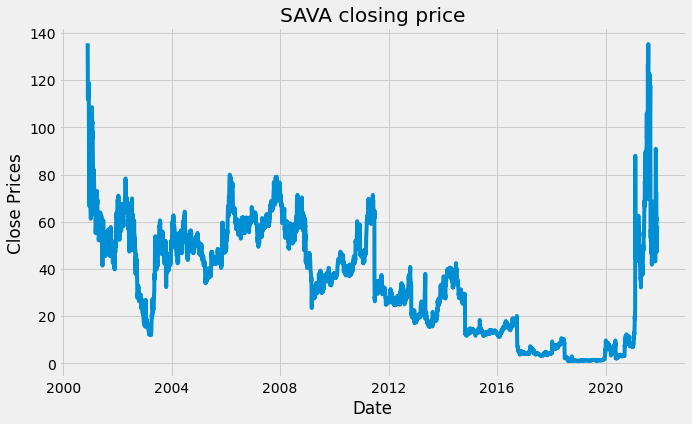

In [155]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('SAVA closing price')
plt.show()

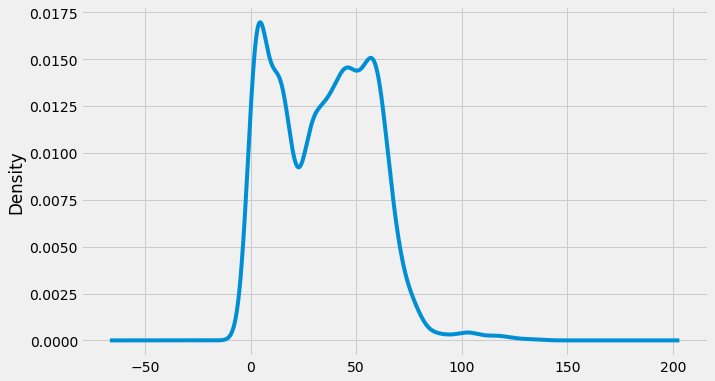

In [156]:
#Distribution of the dataset
stock_data["Close"].plot(kind='kde')

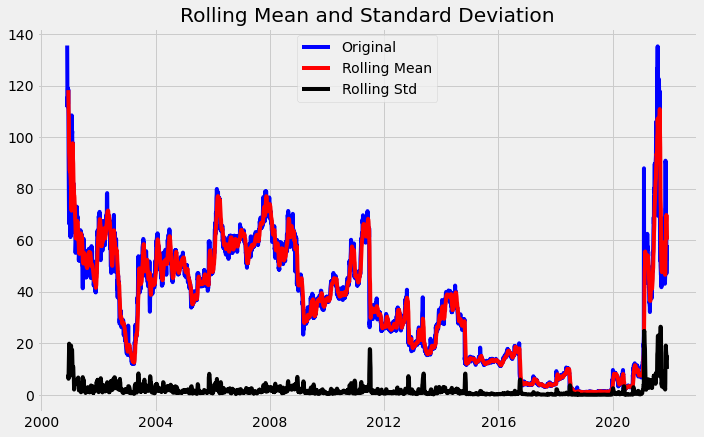

Results of dickey fuller test
Test Statistics                  -2.911164
p-value                           0.044065
No. of lags used                 33.000000
Number of observations used    5247.000000
critical value (1%)              -3.431597
critical value (5%)              -2.862091
critical value (10%)             -2.567063
dtype: float64


In [157]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparision/ARIMA_Stationary.jpg")
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data["Close"])

<Figure size 720x432 with 0 Axes>

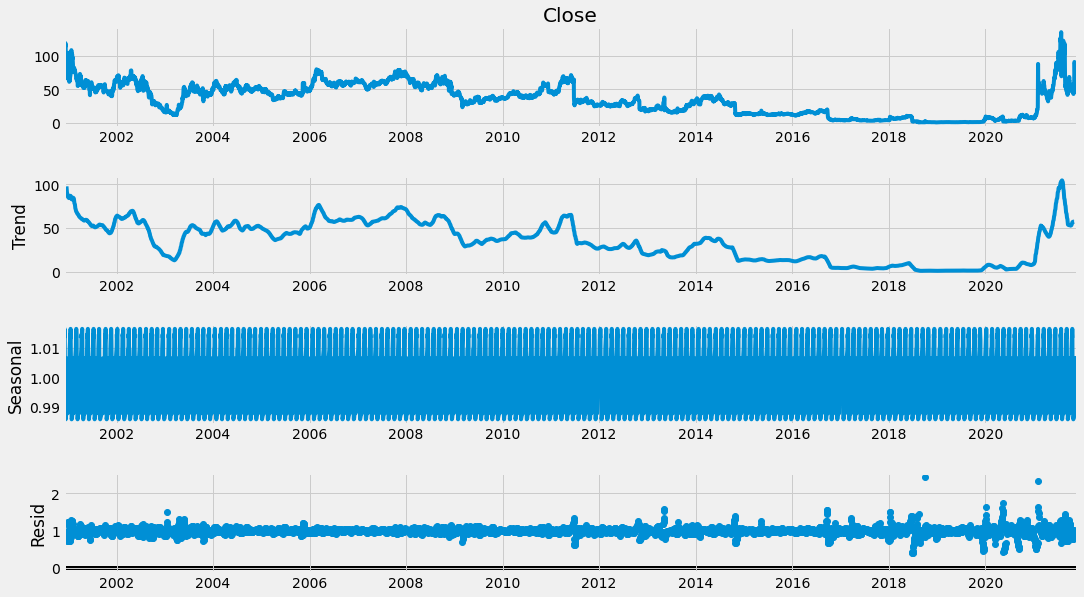

In [158]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(stock_data["Close"], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparision/ARIMA_decompose.jpg")

No handles with labels found to put in legend.


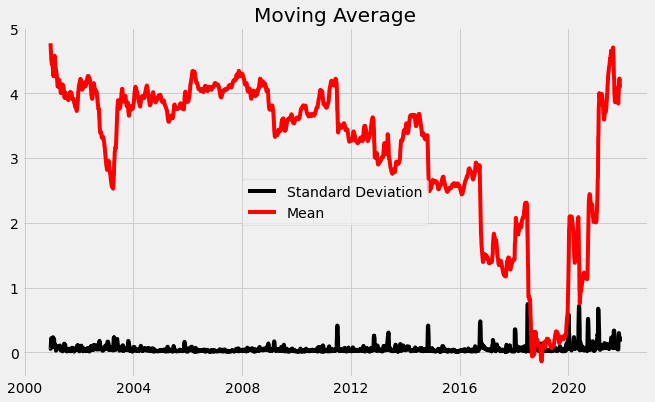

In [159]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data["Close"])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparision/ARIMA_eliminate_trend.jpg")
plt.legend()
plt.show()

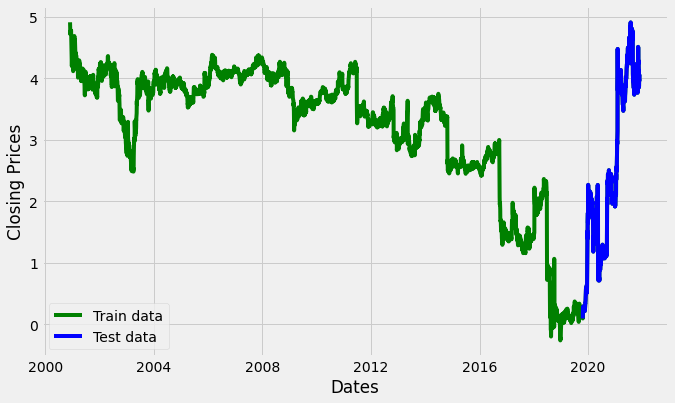

In [160]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13882.645, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13929.814, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13927.072, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13883.256, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13930.968, Time=1.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-13929.276, Time=2.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13928.883, Time=1.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13930.971, Time=1.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13927.469, Time=2.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13930.460, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13927.003, Time=7.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13931.333, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13927.357, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-13930.113, Time=0.19 sec
 ARIM

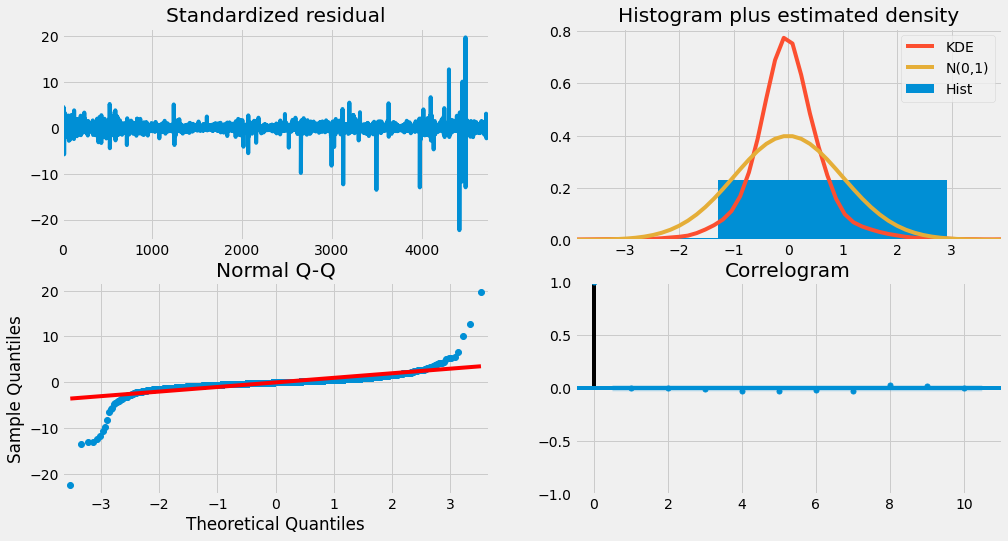

In [161]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [162]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted = model.fit()
  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4749
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6968.676
Date:                Tue, 04 Jan 2022   AIC                         -13931.352
Time:                        21:20:39   BIC                         -13911.956
Sample:                             0   HQIC                        -13924.536
                               - 4749                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0985      0.003    -29.227      0.000      -0.105      -0.092
ar.L2          0.0261      0.011      2.321      0.020       0.004       0.048
sigma2         0.0031   8.75e-06    355.226      0.0

In [163]:
print(len(train_data))

4749


In [198]:
# Forecast
fc = fitted.forecast(steps=529, alpha=0.05)  # 95% conf

for id, i in enumerate(fc.index):
  fc[i] += 0.01 * (id + 1) 

In [199]:
fc.index = test_data.index

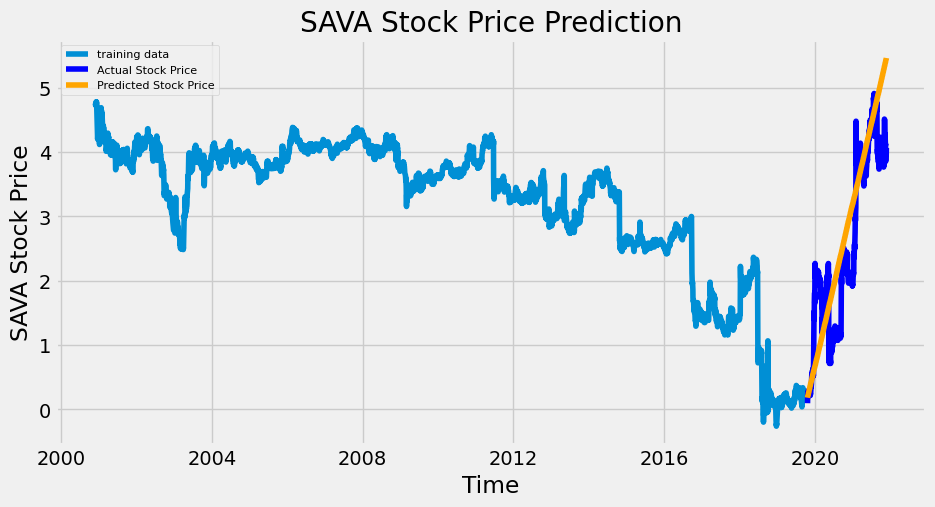

In [204]:
# Make as pandas series
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('SAVA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SAVA Stock Price')
plt.savefig("/content/drive/MyDrive/Intro_DS_2021/Comparision/SAVA_ARIMA_Prediction.jpg")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [203]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.5676749082972876
MAE: 0.6104515377520572
RMSE: 0.7534420404366136
MAPE: 0.3376508339056127
